In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [2]:
dataset = fetch_20newsgroups(subset='all')

X = pd.Series(dataset['data'])
y = pd.Series(dataset['target'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=19)
y_train = pd.get_dummies(y_train)
y_valid = pd.get_dummies(y_valid)

In [3]:
class PositionalEmbedding(L.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = L.Embedding(input_dim, output_dim)
        self.position_embeddings = L.Embedding(sequence_length, output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [4]:
class TransformerEncoder(L.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = L.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([L.Dense(dense_dim, activation='relu'), L.Dense(embed_dim)])
        self.layernorm1 = L.LayerNormalization()
        self.layernorm2 = L.LayerNormalization()
    
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[: tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_confog()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim
        })
        return config

In [5]:
vocab_size = 10_000
embed_dim = 256
num_heads = 2
dense_dim = 32
seq_length = 256

In [6]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<unw>')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(X_train, maxlen=seq_length)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_valid = sequence.pad_sequences(X_valid, maxlen=seq_length)

In [7]:
inputs = keras.Input(shape=(None, ), dtype="int64")
x = PositionalEmbedding(seq_length, vocab_size, embed_dim)(inputs)
# x = L.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = L.GlobalMaxPooling1D()(x)
x = L.Dropout(0.5)(x)
outputs = L.Dense(20, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2021-12-19 16:10:11.494473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 16:10:11.585570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 16:10:11.586280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-19 16:10:11.587406: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
positional_embedding (Positi (None, None, 256)         2625536   
_________________________________________________________________
transformer_encoder (Transfo (None, None, 256)         543776    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                5140      
Total params: 3,174,452
Trainable params: 3,174,452
Non-trainable params: 0
___________________________________________________

In [9]:
es = keras.callbacks.EarlyStopping(verbose=1, patience=5, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)

In [10]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
    callbacks=[es, rlp], epochs=100
)

2021-12-19 16:10:14.184312: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
  4/531 [..............................] - ETA: 9s - loss: 7.4060 - accuracy: 0.0625   

2021-12-19 16:10:16.860267: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


531/531 [==============================] - 13s 19ms/step - loss: 2.4169 - accuracy: 0.3453 - val_loss: 0.8037 - val_accuracy: 0.7660
Epoch 2/100
531/531 [==============================] - 10s 18ms/step - loss: 0.6872 - accuracy: 0.8008 - val_loss: 0.4825 - val_accuracy: 0.8605
Epoch 3/100
531/531 [==============================] - 10s 18ms/step - loss: 0.2896 - accuracy: 0.9106 - val_loss: 0.4973 - val_accuracy: 0.8706
Epoch 4/100
531/531 [==============================] - 10s 18ms/step - loss: 0.1254 - accuracy: 0.9623 - val_loss: 0.5556 - val_accuracy: 0.8658
Epoch 5/100
531/531 [==============================] - 10s 18ms/step - loss: 0.0676 - accuracy: 0.9805 - val_loss: 0.5893 - val_accuracy: 0.8610

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/100
531/531 [==============================] - 10s 18ms/step - loss: 0.0268 - accuracy: 0.9929 - val_loss: 0.5678 - val_accuracy: 0.8790
Epoch 7/100
531/531 [==============================] - 10s 1

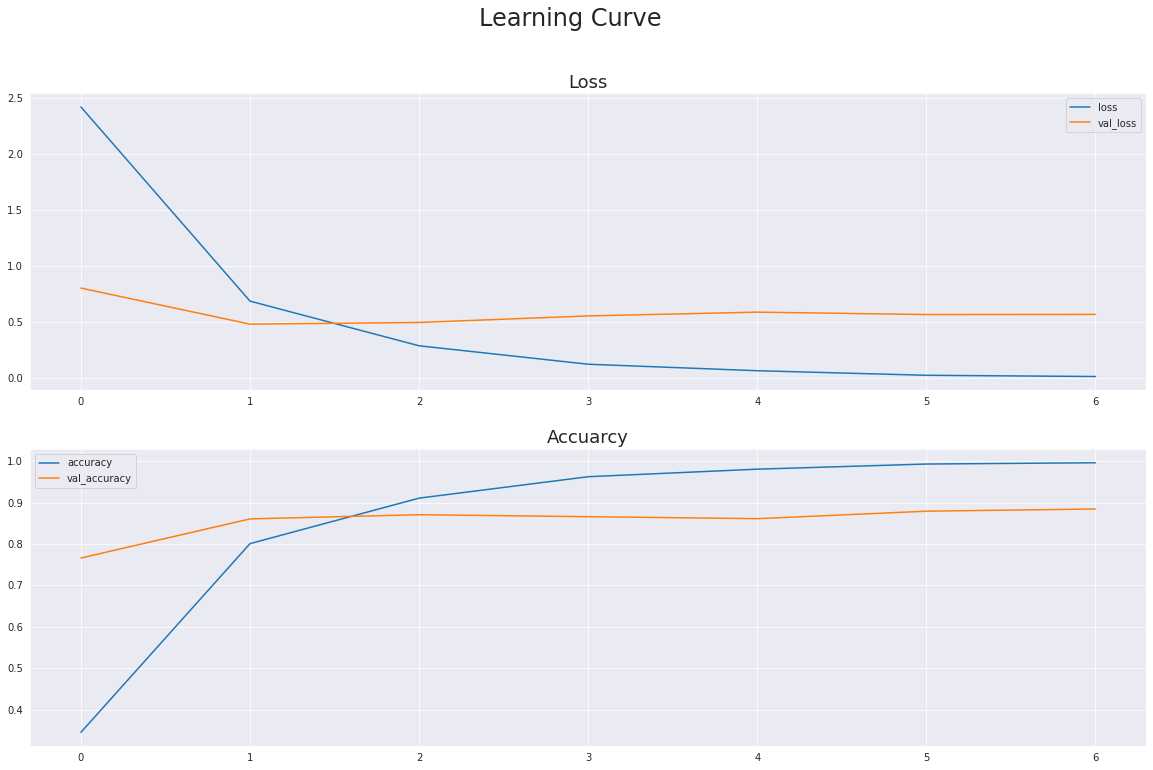

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

history = pd.DataFrame(history.history)
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
fig.suptitle('Learning Curve', fontsize=24)
history[['loss', 'val_loss']].plot(ax=ax[0])
history[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Loss', fontsize=18)
ax[1].set_title('Accuarcy', fontsize=18);